# Random Forest

集成算法
- Bagging 装袋法 RF 基评估器互相独立
- Boosting 提升法 DBDT 基评估器按序建立、逐步提升
- stacking

In [1]:
from sklearn import tree
from sklearn import ensemble
from sklearn.datasets import load_wine
from sklearn.model_selection import train_test_split

### 分类随机森林

导入数据(红酒数据集)

In [2]:
wine = load_wine()

In [3]:
trainX, testX, trainY, testY = train_test_split(wine.data, wine.target, test_size=0.3)

分别创建决策树和随机森林

In [4]:
clf = tree.DecisionTreeClassifier(random_state=20)
rfc = ensemble.RandomForestClassifier(random_state=20)

训练模型

In [5]:
clf.fit(trainX, trainY)
rfc.fit(trainX, trainY)

RandomForestClassifier(random_state=20)

In [6]:
score_c = clf.score(testX, testY)
score_r = rfc.score(testX, testY)
print("tree   -> {} \nforest -> {}".format(score_c, score_r))

tree   -> 0.9444444444444444 
forest -> 0.9629629629629629


交叉验证

In [7]:
from sklearn.model_selection import cross_val_score

In [8]:
clf_cv = tree.DecisionTreeClassifier(random_state=25)
clf_s = cross_val_score(clf_cv, wine.data, wine.target, cv=10)

rfc_cv = ensemble.RandomForestClassifier(random_state=25)
rfc_s = cross_val_score(rfc_cv, wine.data, wine.target, cv=10)

In [9]:
import matplotlib.pyplot as plt

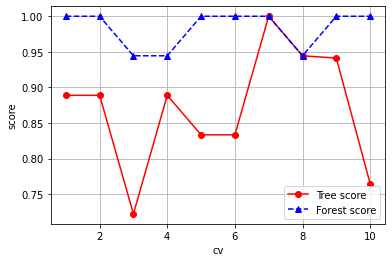

In [10]:
plt.figure()
plt.plot(range(1,11), clf_s, 'ro-', label='Tree score')
plt.plot(range(1,11), rfc_s, 'b^--', label='Forest score')
plt.grid();plt.legend();
plt.xlabel('cv');plt.ylabel('score');
plt.show()

针对 n_estimators 树木数量进行循环并画图

In [11]:
scores = []
for i in range(50):
    rfc_n = ensemble.RandomForestClassifier(random_state=25, n_estimators=i+10)
    rfc_n.fit(trainX, trainY)
    scores.append(rfc_n.score(testX, testY))

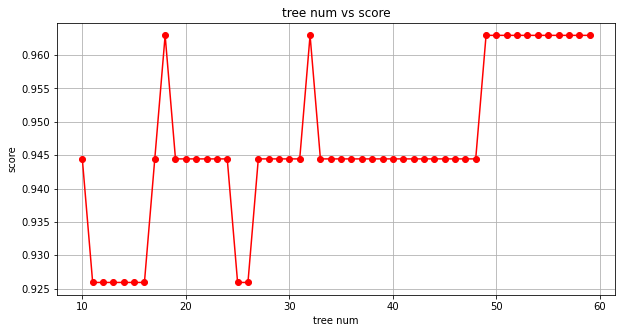

In [12]:
plt.figure(figsize=(10,5))
plt.plot(range(10,60), scores, 'ro-')
plt.title('tree num vs score')
plt.xlabel('tree num');plt.ylabel('score')
plt.grid()
plt.show()

假设有25棵树，每棵树判断错误的概率是 $\epsilon$ 那么最终结果错误的概率是：
$$ P_{error} = \sum_{i=13}^{25} {C_{25}^{i}\epsilon^i(1-\epsilon_i)^{25-i}} $$
假设 $ \epsilon = 0.2 $ 则最终随机森林判错的概率是 $ P_{error} = 0.000369 $

In [13]:
import numpy as np
from scipy.special import comb

np.array([comb(25,i)*(0.2**i)*(0.8**(25-i)) for i in range(13,26)]).sum()

0.00036904803455582827

查看随机森林中树的情况 **estimators_**

In [14]:
rfc.estimators_[0]

DecisionTreeClassifier(max_features='auto', random_state=378518883)

随机森林中 random_state 参数设定后形成的森林是固定的，但是其中每棵树的 random_state 都是不同的

我们更愿意让每棵树都选取不同的 feature 进行训练，这样才能起到树之间互相独立、森林的作用

### bootstrap 有放回随机抽样

对训练数据集，每次取一个样本并放回，共取 $n$ 个，形成一个自助集，共需要 $m$ 个自助集来训练 $m$ 棵树，这样每个自助集都不相同，训练出来的基分类器也各不相同

对于有 $n$ 个样本的数据集，样本 $i$ 被抽到的概率为：
$$ p_i = 1-\left(1-\frac{1}{n}\right)^n$$
当训练集足够大时：
$$ \lim_{n \to +\infty}{1-\left(1-\frac{1}{n}\right)^n} = 1-\left(\frac{1}{e}\right) \approx 0.632 $$

也就说明自助集大概会包含 63% 的原始数据,37% 的数据被称为**袋外数据(oob)**

可以不划分训练测试集，直接采用袋外数据作为测试集，但是只适用于 n 足够大的情况

如果想用袋外数据作为训练集，则要将 oob_score 参数设置为 True， 默认为 False

训练完毕后，可以用 oob_score_ 来查看测试结果

### 装袋法的另一个必要条件
画图说明当基分类器的正确率变化时，随机森林的性能

In [15]:
score_acc = []
x = np.linspace(0,1,30)
for p in x:
    p_i = np.array([comb(25,i)*(p**i)*((1-p)**(25-i)) for i in range(13,26)]).sum()
    score_acc.append(p_i)

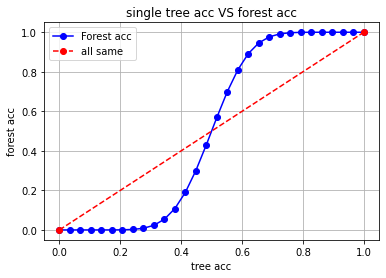

In [16]:
plt.figure()
plt.plot(x, score_acc, 'bo-', label='Forest acc')
plt.plot([x[0],x[29]], [score_acc[0], score_acc[29]], 'ro--', label='all same')
plt.title('single tree acc VS forest acc')
plt.xlabel('tree acc');plt.ylabel('forest acc');
plt.grid();plt.legend()
plt.show()

上图可知，当基分类器正确率小于 0.5 时，整体效率反而下降，因此，**袋装法要求基分类器误差必须小于 0.5**

### 回归随机森林

导入数据(波士顿房价)

In [17]:
from sklearn.datasets import load_boston

In [18]:
boston = load_boston()

In [19]:
rfr = ensemble.RandomForestRegressor(random_state=20, n_estimators=100)
cross_val_score(rfr, boston.data, boston.target, cv=10, scoring='neg_mean_squared_error')

array([-10.20319206,  -5.64001559,  -4.89884624, -23.16874641,
       -11.2196442 , -21.10975616,  -6.77452446, -94.47875096,
       -27.68165804, -14.24676142])

查看所有的模型评价指标

In [20]:
import sklearn
sorted(sklearn.metrics.SCORERS.keys())

['accuracy',
 'adjusted_mutual_info_score',
 'adjusted_rand_score',
 'average_precision',
 'balanced_accuracy',
 'completeness_score',
 'explained_variance',
 'f1',
 'f1_macro',
 'f1_micro',
 'f1_samples',
 'f1_weighted',
 'fowlkes_mallows_score',
 'homogeneity_score',
 'jaccard',
 'jaccard_macro',
 'jaccard_micro',
 'jaccard_samples',
 'jaccard_weighted',
 'max_error',
 'mutual_info_score',
 'neg_brier_score',
 'neg_log_loss',
 'neg_mean_absolute_error',
 'neg_mean_absolute_percentage_error',
 'neg_mean_gamma_deviance',
 'neg_mean_poisson_deviance',
 'neg_mean_squared_error',
 'neg_mean_squared_log_error',
 'neg_median_absolute_error',
 'neg_root_mean_squared_error',
 'normalized_mutual_info_score',
 'precision',
 'precision_macro',
 'precision_micro',
 'precision_samples',
 'precision_weighted',
 'r2',
 'rand_score',
 'recall',
 'recall_macro',
 'recall_micro',
 'recall_samples',
 'recall_weighted',
 'roc_auc',
 'roc_auc_ovo',
 'roc_auc_ovo_weighted',
 'roc_auc_ovr',
 'roc_auc_ovr_we